In [0]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

import keras
keras.__version__

1.15.2


'2.3.1'

In [0]:
import os, shutil

from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Using a pre-trained convnet: transfer learning

A pre-trained network is simply a saved network previously trained on a large dataset. If this original 
dataset is large enough and general enough, then the spatial feature learned by the pre-trained network can effectively act as a generic model of our visual world, and hence its features can prove useful for many different computer vision problems.

In our case, we will consider a large convnet trained on ImageNet and we will use the VGG16 architecture.

There are two ways to leverage a pre-trained network: *feature extraction* and *fine-tuning*. 

---



## 2.1. Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. 

Convnets used for image classification comprise two parts: they start with a series of pooling and convolution 
layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of 
convnets, "feature extraction" simply consists of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

<font color ='red'> Why only reuse the convolutional base? Could we reuse the densely-connected classifier as well? </font>

The reason why we only reuse the convolutional base is because the convolutional base netowrk contains generic features for classifying pictures, therefore it applies to different applications of classifying pictures. We cannot reuse the densely-connected classifier because part of the pretrained model is specific to the original classification task, and specific to the set of classes on which the model was trained. Thus, the densely-connected classifier is not as generic and cannot be reused like the convolutional base. 



Let's instantiate the VGG16 model:

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected classifier (with only two classes, cat and dog), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, then the network will be able to process inputs of any size.

Let's have a look at the VGG models with its numbers of parameters.

In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

The final feature map has shape `(4, 4, 512)`. That's the feature on top of which we will stick a densely-connected classifier.

There are two ways we could proceed: 

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier . This solution is very fast and cheap to run. However, this technique would not allow us to leverage data augmentation at all.

* Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation. However, for this same reason, this technique is far more expensive than the first one.

We will cover both techniques. 

###2.1.1. Technique 1

We will start by running instances of the previously-introduced `ImageDataGenerator` to extract images and their labels.

In [0]:
!wget https://www.dropbox.com/s/i2rikoreagea5ky/dog-cat-small.zip?dl=0 \
    -O /content/drive/My\ Drive/dog-cat-small.zip


--2020-04-18 03:34:05--  https://www.dropbox.com/s/i2rikoreagea5ky/dog-cat-small.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/i2rikoreagea5ky/dog-cat-small.zip [following]
--2020-04-18 03:34:05--  https://www.dropbox.com/s/raw/i2rikoreagea5ky/dog-cat-small.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6aab61af49245aef94b74b26ee.dl.dropboxusercontent.com/cd/0/inline/A2CbFXIZsHDwsnd57sobp056qM8bMqvAyz_g5ukEKbAIqS-faoQOPOq0exxC8K02e8FXPWjNSEkMvbhO-mGPmotNrWBTnClVM5-naj4UHW8jk8nRXCZsgz0P8J_VPrC51GM/file# [following]
--2020-04-18 03:34:05--  https://uc6aab61af49245aef94b74b26ee.dl.dropboxusercontent.com/cd/0/inline/A2CbFXIZsHDwsnd57sobp056qM8bMqvAyz_g5ukEKbAIqS-faoQOPOq0exxC8K02e8FXPWjNSEkMvbhO-mGPmotNrWB

In [0]:
import zipfile

local_zip = '/content/drive/My Drive/dog-cat-small.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/My Drive/dog-cat-small')
zip_ref.close()

In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/drive/My Drive/dog-cat-small' #TODO

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    # TODO
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    # end TODO
    
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    
    for inputs_batch, labels_batch in generator:
        # TODO
        features_batch = conv_base.predict(inputs_batch)
        # end TODO
        
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must 
flatten them to `(samples, 8192)`:

In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and 
labels that we just recorded:

In [0]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()


# TODO
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))
# end TODO
        


model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 457us/step - loss: 0.6068 - acc: 0.6645 - val_loss: 0.4608 - val_acc: 0.8300
Epoch 2/30
2000/2000 [==============================] - 1s 332us/step - loss: 0.4592 - acc: 0.8000 - val_loss: 0.3573 - val_acc: 0.8630
Epoch 3/30
2000/2000 [==============================] - 1s 322us/step - loss: 0.3592 - acc: 0.8485 - val_loss: 0.3070 - val_acc: 0.8730
Epoch 4/30
2000/2000 [==============================] - 1s 328us/step - loss: 0.3312 - acc: 0.8620 - val_loss: 0.2843 - val_acc: 0.8870
Epoch 5/30
2000/2000 [==============================] - 1s 319us/step - loss: 0.2963 - acc: 0.8775 - val_loss: 0.2676 - val_acc: 0.8900
Epoch 6/30
2000/2000 [==============================] - 1s 323us/step - loss: 0.2722 - acc: 0.8815 - val_loss: 0.2624 - val_acc: 0.9000
Epoch 7/30
2000/2000 [==============================] - 1s 324us/step - loss: 0.2452 - acc: 0.9010 - val_loss: 0.2665 - val_acc: 0.8900


Training is very fast, since we only have to deal with two `Dense` layers.

Let's take a look at the loss and accuracy curves during training:

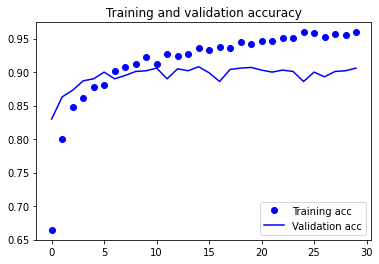

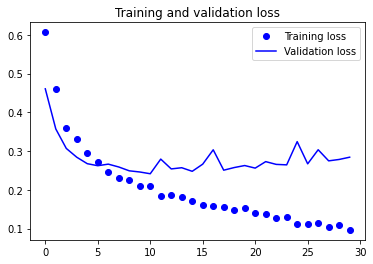

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


We reach a validation accuracy of about 90%. However, our plots also indicate that we are overfitting almost from the start. This is because this technique does not leverage data augmentation.

###2.1.2. Technique 2

This is much slower and more expensive, but which allows 
us to leverage data augmentation during training: extending the `conv_base` model and running it end-to-end on the inputs. 

You need to use GPU.

So you can do the following:

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(rate = 0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what our model looks like now:

In [0]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_58 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_59 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 129       
Total params: 16,845,121
Trainable params: 2,130,433
Non-trainable params: 14,714,688
_________________________________

As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 
million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. 

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

In [0]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 6


In [0]:
conv_base.trainable = False

In [0]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 6


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per 
layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 
If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 22s - loss: 0.5727 - acc: 0.7200 - val_loss: 0.3253 - val_acc: 0.8780
Epoch 2/30
 - 20s - loss: 0.3628 - acc: 0.8740 - val_loss: 0.2584 - val_acc: 0.9110
Epoch 3/30
 - 21s - loss: 0.2508 - acc: 0.9200 - val_loss: 0.0818 - val_acc: 0.9130
Epoch 4/30
 - 21s - loss: 0.2076 - acc: 0.9250 - val_loss: 0.2460 - val_acc: 0.9230
Epoch 5/30
 - 20s - loss: 0.1700 - acc: 0.9420 - val_loss: 0.0546 - val_acc: 0.9300
Epoch 6/30
 - 21s - loss: 0.1422 - acc: 0.9490 - val_loss: 0.1852 - val_acc: 0.9340
Epoch 7/30
 - 20s - loss: 0.1214 - acc: 0.9595 - val_loss: 0.0130 - val_acc: 0.9340
Epoch 8/30
 - 21s - loss: 0.1199 - acc: 0.9540 - val_loss: 0.1623 - val_acc: 0.9330
Epoch 9/30
 - 21s - loss: 0.1084 - acc: 0.9600 - val_loss: 0.0497 - val_acc: 0.9340
Epoch 10/30
 - 20s - loss: 0.0952 - acc: 0.9675 - val_loss: 0.2819 - val_acc: 0.9330
Epoch 11/30
 - 21s - loss: 0.0919 - acc: 0.9720 - val_loss: 0.1616 - val_ac

In [0]:
model.save('cats_and_dogs_small_3.h5')

Let's plot our results again:

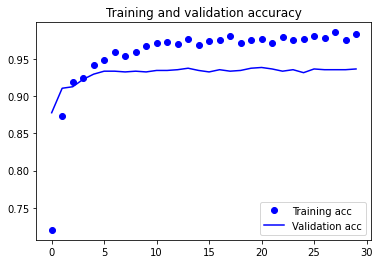

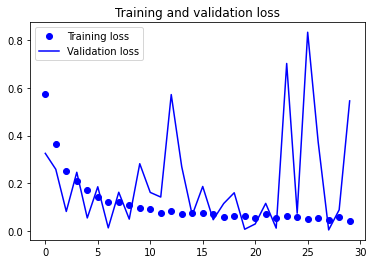

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As you can see, we reach a validation accuracy of about 96%. This is much better than our small convnet trained from scratch.

## 2.2. Fine-tuning

Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the 
fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

It is only possible to fine-tune the top layers of the convolutional base once the classifier on 
top has already been trained. The steps for fine-tuning a network are as follow:

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our `conv_base`, 
and then freeze individual layers inside of it.



We will fine-tune the last 3 convolutional layers, which means that all layers up until `block4_pool` should be frozen, and the layers 
`block5_conv1`, `block5_conv2` and `block5_conv3` should be trainable.

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate.


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 23s 228ms/step - loss: 0.0742 - acc: 0.9735 - val_loss: 0.0019 - val_acc: 0.9350
Epoch 2/100
100/100 [==============================] - 21s 214ms/step - loss: 0.0554 - acc: 0.9825 - val_loss: 7.8618e-04 - val_acc: 0.9320
Epoch 3/100
100/100 [==============================] - 22s 217ms/step - loss: 0.0633 - acc: 0.9725 - val_loss: 0.0139 - val_acc: 0.9380
Epoch 4/100
100/100 [==============================] - 21s 214ms/step - loss: 0.0558 - acc: 0.9790 - val_loss: 0.0887 - val_acc: 0.9330
Epoch 5/100
100/100 [==============================] - 21s 211ms/step - loss: 0.0641 - acc: 0.9780 - val_loss: 0.3763 - val_acc: 0.9380
Epoch 6/100
100/100 [==============================] - 22s 222ms/step - loss: 0.0591 - acc: 0.9770 - val_loss: 0.0782 - val_acc: 0.9340
Epoch 7/100
100/100 [==============================] - 22s 222ms/step - loss: 0.0552 - acc: 0.9810 - val_loss: 0.0141 - val_acc: 0.9420
Epoch 8/100
100/100 [=======================

In [0]:
model.save('cats_and_dogs_small_4.h5')

Let's plot our results using the same plotting code as before:

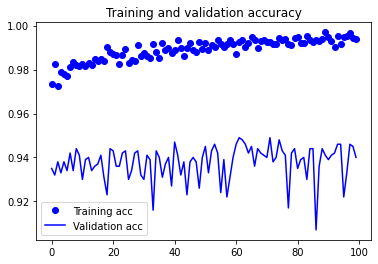

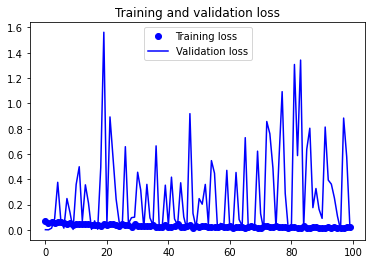

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving 
averages of these quantities. Here's a trivial utility function to do this:

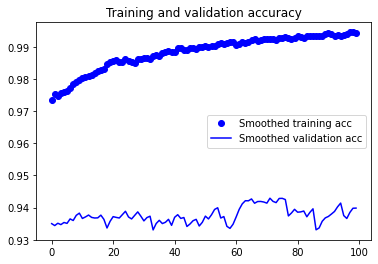

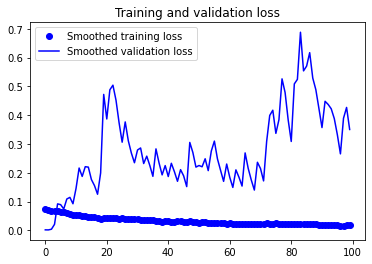

In [0]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


These curves look much cleaner and more stable. We are seeing a nice 1% absolute improvement.

We can now finally evaluate this model on the test data:

In [0]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9390000104904175



Here we get a test accuracy of 97%.

To increase the validation and test accuracy, I have tried adding more dense layers to multiple different cells, as well as adding regularization layers (such as drop out). This resulted in running the epochs countless times, and none of these techniques have worked to increase the test accuracy to 97.
